### Testing Raw Cible WB

## Part 1: Setup and Data Loading


In [1]:
### Dowload and install dependencies for the project
# %matplotlib inline
%pip install setuptools wheel cython
%pip install statsmodels


[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
### ====================
### Importing libraries
### ====================
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#import shap
import os
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
### ====================
### Set up visualization and warnings
### ====================
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
# sns.set_palette('viridis')


2025-06-04 15:05:08.101527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-04 15:05:08.335623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-04 15:05:08.335721: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-04 15:05:08.385876: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 15:05:09.751982: W tensorflow/stream_executor/platform/de

In [3]:
### ====================
### File paths
###  ===================
# Create directories for model saving
models_dir = '../../models'
for model_type in ['simple_models', 'ml_models', 'dl_models']:
    models_dir = os.path.join(models_dir, model_type)
    os.makedirs(models_dir, exist_ok=True)

# Load Excel file
maquettes_path = "../../data/raw/"
maquettes= ["RawData-Cibles.xlsx"]
for maquette in maquettes:
    maquettes_path = os.path.join(maquettes_path, maquette)
sheets = ["Mur", "Sols", "Poutre", "Poteaux"]  # Adjusted based on your description


## Import Pythoon Modules
import sys
sys.path.append("../../module_python")


In [ ]:
import excel_data_loader
data = excel_data_loader.load_data(maquettes_path)


# Access the DataFrames
murs_df = data.get('Murs')
sols_df = data.get('Sols')
poutres_df = data.get('Poutres')
poteaux_df = data.get('Poteaux')

# Display basic info
print("Murs DataFrame Shape:", murs_df.shape)
print("Sols DataFrame Shape:", sols_df.shape)
print("Poutres DataFrame Shape:", poutres_df.shape)
print("Poteaux DataFrame Shape:", poteaux_df.shape)

# Display column names
for sheet_name, df in data.items():
    print(f"\n{sheet_name} DataFrame Preview:")
    print(df.columns)

Data loaded successfully from the Excel file.
Murs DataFrame Shape: (312, 96)
Sols DataFrame Shape: (107, 94)
Poutres DataFrame Shape: (246, 100)
Poteaux DataFrame Shape: (68, 87)

Murs DataFrame Preview:
Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie',
       'Section', 'Type prédéfini d'IFC', 'Exporter au format IFC sous',
       'Exporter au format IFC', 'IfcGUID', 'A une association',
       'Enrobage d'armature - Autres faces',
       'Enrobage d'armature - Face intérieure',
       'Enrobage d'armature - Face extérieure', 'Variantes',
       'Extension inférieure', 'Extension supérieure', 'Volume',

## Part 2: Data Preprocessing and Relationship Mapping


In [5]:
### ====================
### Cleaned DataFrames Loading
### ====================
import excel_essential_columns_cleaner
dataframes = excel_essential_columns_cleaner.load_and_clean_data(maquettes_path)


✅ Murs: Kept 31/31 columns | New shape: (312, 31)
✅ Sols: Kept 23/23 columns | New shape: (107, 23)
✅ Poutres: Kept 23/23 columns | New shape: (246, 23)
✅ Poteaux: Kept 26/26 columns | New shape: (68, 26)

Cleaned DataFrame Shapes:
Murs: (312, 31)
Sols: (107, 23)
Poutres: (246, 23)
Poteaux: (68, 26)

Column Names in Cleaned DataFrames:

Columns in Murs:
Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Profil modifié', 'Extension inférieure',
       'Extension supérieure', 'Volume', 'Surface',
       'Partie inférieure attachée', 'Partie supérieure attachée',
       'Décalage supérieur', 'Décalage inférieur', 'Matériau structurel'],
      dtype='object')

Columns

In [6]:
print(type(dataframes))  # Debugging check

<class 'dict'>


In [7]:
### ====================
### Verify that all critical columns are present
### ====================
import excel_critical_columns_validator

dataframes, missing_critical, murs_df, sols_df, poutres_df, poteaux_df = excel_critical_columns_validator.validate_critical_columns(dataframes)

# Print results
print(missing_critical)
print(murs_df.shape, sols_df.shape, poutres_df.shape, poteaux_df.shape)

{'Murs': [], 'Sols': [], 'Poutres': [], 'Poteaux': []}
(312, 31) (107, 23) (246, 23) (68, 26)


In [15]:
import excel_clean_ids_columns

df_dict = {
    'Murs': murs_df,
    'Sols': sols_df,
    'Poutres': poutres_df,
    'Poteaux': poteaux_df
}

cleaned_dfs = excel_clean_ids_columns.clean_ids_columns(df_dict)

# Update DataFrames
murs_df = cleaned_dfs['Murs']
sols_df = cleaned_dfs['Sols']
poutres_df = cleaned_dfs['Poutres']
poteaux_df = cleaned_dfs['Poteaux']



🔍 Processing Murs...
✅ Processing Column Pair: Sols coupés (u) → Sols coupés (Ids)
✅ Cleaned 0 rows in Sols coupés (Ids)
✅ Processing Column Pair: Sols coupants (u) → Sols coupants (Ids)
✅ Cleaned 0 rows in Sols coupants (Ids)
🚨 Skipping: Murs coupés (u) or Murs coupés (Ids) not found in Murs
🚨 Skipping: Murs coupants (u) or Murs coupants (Ids) not found in Murs
🚨 Skipping: Poutres coupés (u) or Poutres coupés (Ids) not found in Murs
🚨 Skipping: Poutres coupants (u) or Poutres coupants (Ids) not found in Murs
🚨 Skipping: Poteaux coupés (u) or Poteaux coupés (Ids) not found in Murs
🚨 Skipping: Poteaux coupants (u) or Poteaux coupants (Ids) not found in Murs

🔍 Processing Sols...
🚨 Skipping: Sols coupés (u) or Sols coupés (Ids) not found in Sols
🚨 Skipping: Sols coupants (u) or Sols coupants (Ids) not found in Sols
✅ Processing Column Pair: Murs coupés (u) → Murs coupés (Ids)
✅ Cleaned 0 rows in Murs coupés (Ids)
✅ Processing Column Pair: Murs coupants (u) → Murs coupants (Ids)
✅ Cleane

In [45]:
def count_ids_per_row(df_dict, id_columns):
    """
    Counts the number of IDs in every row of specified columns across multiple DataFrames.

    Args:
        df_dict (dict): Dictionary of DataFrames (e.g., {"Murs": murs_df, "Sols": sols_df, ...})
        id_columns (list): List of columns containing multiple IDs.

    Returns:
        Updated DataFrames with new count columns added.
    """
    for df_name, df in df_dict.items():
        print(f"🔍 Processing {df_name}...")
        for col in id_columns:
            if col in df.columns:
                # Convert to string, replace empty values or "0" with NaN
                df[col] = df[col].astype(str).replace(['nan', 'None', '0', '', ' '], np.nan)

                # Count number of valid IDs in each row
                df[f"{col}_count"] = df[col].apply(lambda x: len(str(x).split(",")) if pd.notna(x) else 0)

    return df_dict

In [49]:
df_dict = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}

id_columns = [
    "Sols coupés (Ids)", "Sols coupants (Ids)",
    "Murs coupés (Ids)", "Murs coupants (Ids)",
    "Poutres coupés (Ids)", "Poutres coupants (Ids)",
    "Poteaux coupés (Ids)", "Poteaux coupants (Ids)"
]

# Apply refined function
df_dict = count_ids_per_row(df_dict, id_columns)

# Extract updated DataFrames
murs_df, sols_df, poutres_df, poteaux_df = df_dict["Murs"], df_dict["Sols"], df_dict["Poutres"], df_dict["Poteaux"]

# Check results for each DataFrame (only columns that exist in each)
for name, df in zip(['Murs', 'Sols', 'Poutres', 'Poteaux'], [murs_df, sols_df, poutres_df, poteaux_df]):
    df_count_cols = [col + "_count" for col in id_columns if (col + "_count") in df.columns]
    print(f"\n{name} DataFrame count columns:")
    if df_count_cols:
        print(df[df_count_cols].head())
    else:
        print("No count columns found.")

🔍 Processing Murs...
🔍 Processing Sols...
🔍 Processing Poutres...
🔍 Processing Poteaux...

Murs DataFrame count columns:
   Sols coupés (Ids)_count  Sols coupants (Ids)_count
0                        0                          3
1                        0                          1
2                        0                          1
3                        0                          0
4                        0                          2

Sols DataFrame count columns:
   Murs coupés (Ids)_count  Murs coupants (Ids)_count  \
0                        0                          0   
1                        9                          0   
2                        3                          0   
3                       12                          0   
4                        0                          0   

   Poutres coupés (Ids)_count  Poutres coupants (Ids)_count  \
0                           1                             0   
1                           1                          

In [50]:
import pandas as pd
import numpy as np

def link_id_relationships(df_dict, relation_mapping):
    """
    Links related features between DataFrames based on referenced IDs.

    Args:
        df_dict (dict): Dictionary of DataFrames {'Murs': murs_df, 'Sols': sols_df, ...}
        relation_mapping (dict): Mapping of relationship columns to their target DataFrame.

    Returns:
        Updated df_dict with linked features.
    """
    for main_df_name, main_df in df_dict.items():
        for ids_col, target_df_name in relation_mapping.items():
            if ids_col in main_df.columns and target_df_name in df_dict:
                print(f"🔍 Linking {ids_col} in {main_df_name} → {target_df_name}")

                # Explode IDs (split if multiple values exist)
                exploded_df = main_df[[ids_col]].copy()
                exploded_df[ids_col] = exploded_df[ids_col].astype(str).str.split(',')
                exploded_df = exploded_df.explode(ids_col).dropna()
                exploded_df[ids_col] = pd.to_numeric(exploded_df[ids_col], errors='coerce')

                # Get the corresponding target DataFrame
                target_df = df_dict[target_df_name]

                # Merge exploded IDs with related DataFrame
                merged_df = exploded_df.merge(target_df, left_on=ids_col, right_on='Id', how='left')

                # Aggregate feature values
                feature_columns = [col for col in target_df.columns if col != 'Id']
                for feature in feature_columns:
                    new_col_name = f"{target_df_name}_{feature}"

                    # Numeric aggregation (mean)
                    if np.issubdtype(merged_df[feature].dtype, np.number):
                        main_df[new_col_name] = merged_df.groupby(merged_df.index)[feature].mean()

                    # Categorical aggregation (mode with empty check)
                    else:
                        main_df[new_col_name] = merged_df.groupby(merged_df.index)[feature].agg(
                            lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
                        )

                print(f"✅ Linked features from {target_df_name} into {main_df_name}")

    return df_dict

In [51]:
# Dictionary containing all DataFrames
df_dict = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}

# Define relationships between ID columns and their respective target DataFrames
relation_mapping = {
    "Sols coupés (Ids)": "Sols",
    "Sols coupants (Ids)": "Sols",
    "Murs coupés (Ids)": "Murs",
    "Murs coupants (Ids)": "Murs",
    "Poutres coupés (Ids)": "Poutres",
    "Poutres coupants (Ids)": "Poutres",
    "Poteaux coupés (Ids)": "Poteaux",
    "Poteaux coupants (Ids)": "Poteaux"
}

# Apply the linking function
df_dict = link_id_relationships(df_dict, relation_mapping)

# Extract updated DataFrames
murs_df, sols_df, poutres_df, poteaux_df = df_dict["Murs"], df_dict["Sols"], df_dict["Poutres"], df_dict["Poteaux"]

🔍 Linking Sols coupés (Ids) in Murs → Sols
✅ Linked features from Sols into Murs
🔍 Linking Sols coupants (Ids) in Murs → Sols
✅ Linked features from Sols into Murs
🔍 Linking Murs coupés (Ids) in Sols → Murs
✅ Linked features from Murs into Sols
🔍 Linking Murs coupants (Ids) in Sols → Murs
✅ Linked features from Murs into Sols
🔍 Linking Poutres coupés (Ids) in Sols → Poutres
✅ Linked features from Poutres into Sols
🔍 Linking Poutres coupants (Ids) in Sols → Poutres
✅ Linked features from Poutres into Sols
🔍 Linking Poteaux coupés (Ids) in Sols → Poteaux
✅ Linked features from Poteaux into Sols
🔍 Linking Poteaux coupants (Ids) in Sols → Poteaux
✅ Linked features from Poteaux into Sols
🔍 Linking Sols coupés (Ids) in Poutres → Sols
✅ Linked features from Sols into Poutres
🔍 Linking Sols coupants (Ids) in Poutres → Sols
✅ Linked features from Sols into Poutres
🔍 Linking Poteaux coupés (Ids) in Poutres → Poteaux
✅ Linked features from Poteaux into Poutres
🔍 Linking Sols coupés (Ids) in Potea

In [52]:
# Check if new features were added
print(murs_df.head())
print(sols_df.head())
print(poutres_df.head())
print(poteaux_df.head())

# Verify a specific linked feature
print(murs_df[['Sols coupants (Ids)', 'Sols_Volume']].head())  # Example feature from Sols

        Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  1787858        GO           MUR          EXTERIEUR                 BANCHE   
1  1787860        GO           MUR          EXTERIEUR                 BANCHE   
2  1787874        GO           MUR                 JD                 BANCHE   
3  1787876        GO           MUR                 JD                 BANCHE   
4  1787878        GO           MUR                 JD                 BANCHE   

   Hauteur  Epaisseur    AI    AS  Sols en intersection  Sols coupés (u)  \
0     3.32       0.25 -0.02  3.30                     0                0   
1     3.32       0.20 -0.02  3.30                     0                0   
2     3.32       0.20 -0.02  3.30                     0                0   
3     4.04       0.20 -0.13  3.91                     1                0   
4     4.33       0.20 -0.13  4.20                     0                0   

   Sols coupés (Ids)  Sols coupants (u)      Sols coupants (Id

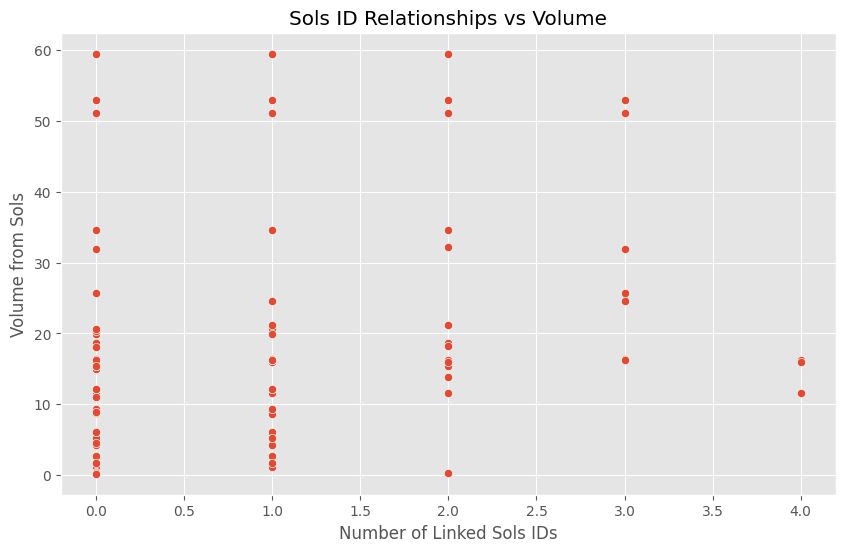

In [55]:
import seaborn as sns

# Example: Plot Murs IDs linked to Sols Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x=murs_df["Sols coupants (Ids)_count"], y=murs_df["Sols_Volume"])
plt.xlabel("Number of Linked Sols IDs")
plt.ylabel("Volume from Sols")
plt.title("Sols ID Relationships vs Volume")
plt.show()

In [ ]:
def full_validation():
    """Run a concise validation suite across all DataFrames."""

    dfs = {"Murs": murs_df, "Sols": sols_df, "Poutres": poutres_df, "Poteaux": poteaux_df}

    for name, df in dfs.items():
        if not isinstance(df, pd.DataFrame):
            print(f"❌ {name}: Not a valid DataFrame")
            continue

        print(f"\n🔍 Validating {name}: Shape {df.shape}, Columns: {len(df.columns)}")
        rel_cols = [c for c in df.columns if "coup" in c.lower()]
        created_features = [c for c in df.columns if any(x in c for x in ["sol_", "mur_", "poutre_", "poteau_"])]

        print(f"🔗 Relationship columns ({len(rel_cols)}): {rel_cols}")
        print(f"🆕 Created features ({len(created_features)}): {created_features[:5] if created_features else 'None'}")

    # Quick relationship feature check
    for main, rel, prefix in [
        (murs_df, sols_df, "Sols coupés (Ids)", "sol"),
        (murs_df, sols_df, "Sols coupants (Ids)", "sol"),
        (sols_df, murs_df, "Murs coupés (Ids)", "murs"),
        (sols_df, poutres_df, "Poutres coupés (Ids)", "poutres"),
        (poutres_df, poteaux_df, "Poteaux coupés (Ids)", "poteaux")
    ]:
        if isinstance(main, pd.DataFrame) and rel is not None and prefix + "_Hauteur" in main.columns:
            print(f"\n✅ {prefix}: Features validated in {main.shape[0]} rows")
            print(main[[prefix + "_Hauteur", prefix + "_Epaisseur"]].head(2))

full_validation()


🔍 Validating Murs: Shape (312, 706), Columns: 706
🔗 Relationship columns (244): ['Sols coupés (u)', 'Sols coupés (Ids)', 'Sols coupants (u)', 'Sols coupants (Ids)', 'Sols_Murs coupés (u)', 'Sols_Murs coupés (Ids)', 'Sols_Murs coupants (u)', 'Sols_Murs coupants (Ids)', 'Sols_Poutres coupés (u)', 'Sols_Poutres coupés (Ids)', 'Sols_Poutres coupants (u)', 'Sols_Poutres coupants (Ids)', 'Sols_Poteaux coupés (u)', 'Sols_Poteaux coupés (Ids)', 'Sols_Poteaux coupants (u)', 'Sols_Poteaux coupants (Ids)', 'Sols_Murs_Sols coupés (u)', 'Sols_Murs_Sols coupés (Ids)', 'Sols_Murs_Sols coupants (u)', 'Sols_Murs_Sols coupants (Ids)', 'Sols_Murs_Sols_Murs coupés (u)', 'Sols_Murs_Sols_Murs coupés (Ids)', 'Sols_Murs_Sols_Murs coupants (u)', 'Sols_Murs_Sols_Murs coupants (Ids)', 'Sols_Murs_Sols_Poutres coupés (u)', 'Sols_Murs_Sols_Poutres coupés (Ids)', 'Sols_Murs_Sols_Poutres coupants (u)', 'Sols_Murs_Sols_Poutres coupants (Ids)', 'Sols_Murs_Sols_Poteaux coupés (u)', 'Sols_Murs_Sols_Poteaux coupés (Ids)'

ValueError: too many values to unpack (expected 3)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract numerical columns for correlation mapping
corr_matrix = murs_df.select_dtypes(include=['number']).corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## Part 3: Feature Engineering and Target Preparation

In [ ]:
# Feature selection for Murs DataFrame
# We'll exclude the target columns and ID columns from features
excluded_features = target_columns + ['Id', 'Sols coupés (Ids)', 'Sols coupants (Ids)']
features = [col for col in mur_df.columns if col not in excluded_features]

# Separate features and targets
X = mur_df[features]
y = mur_df[target_columns]

# Handle categorical features (text with special French characters)
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=np.number).columns

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# For multi-label classification, we'll use separate models for each target
# Or we can combine them into a single target (less recommended due to different natures)
# Here we'll proceed with separate models

# Get feature names after one-hot encoding
# For numeric features
numeric_feature_names = numeric_cols.tolist()

# For categorical features
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    all_feature_names = numeric_feature_names + categorical_feature_names
else:
    all_feature_names = numeric_feature_names

print(f"Total features after preprocessing: {len(all_feature_names)}")

## Part 4: Exploratory Data Analysis and Correlation Analysis

In [ ]:
# Correlation analysis for each target variable
plt.figure(figsize=(15, 10))

# For numeric features only (correlation requires numeric data)
numeric_df = X[numeric_cols]

# Add targets to the numeric_df for correlation
for target in target_columns:
    if target in mur_df.columns:
        # Encode target for correlation
        le = LabelEncoder()
        encoded_target = le.fit_transform(mur_df[target])
        numeric_df[target] = encoded_target

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap for each target
for i, target in enumerate(target_columns, 1):
    if target in numeric_df.columns:
        plt.subplot(2, 2, i)
        target_corr = corr_matrix[target].sort_values(ascending=False)
        sns.barplot(x=target_corr.values[1:11], y=target_corr.index[1:11])
        plt.title(f'Top 10 Features Correlated with {target}')
        plt.tight_layout()

plt.show()

# Analyze distribution of target variables
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_columns, 1):
    if target in mur_df.columns:
        plt.subplot(2, 2, i)
        sns.countplot(y=mur_df[target], order=mur_df[target].value_counts().index)
        plt.title(f'Distribution of {target}')
        plt.tight_layout()

plt.show()

# SHAP analysis for feature importance (sample for one target)
if '012EC_Ouvrage' in mur_df.columns:
    # Sample a subset for faster SHAP computation
    X_sample = X_processed[:1000] if X_processed.shape[0] > 1000 else X_processed

    # Train a model for this target
    y_target = mur_df['012EC_Ouvrage']
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_target)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_encoded, test_size=0.2, random_state=42)

    # Train a model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Plot summary
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, class_names=le.classes_)
    plt.title('SHAP Summary for 012EC_Ouvrage Prediction')
    plt.show()

## Part 5: Model Training and Evaluation


In [ ]:
# Function to train and evaluate models for a target variable
def train_evaluate_models(X, y, target_name, models):
    """
    Train and evaluate multiple models for a target variable

    Args:
        X: Features (processed)
        y: Target variable
        target_name: Name of the target variable
        models: Dictionary of models to evaluate

    Returns:
        Dictionary of model performances
    """
    # Encode target if categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for {target_name}...")

        try:
            # Train model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1': report['weighted avg']['f1-score']
            }

            print(f"{model_name} Accuracy: {accuracy:.4f}")

            # Save model based on type
            if hasattr(model, 'layers'):  # Keras model
                model_path = f"dlmodels/{target_name}_{model_name}.h5"
                model.save(model_path)
            elif 'boost' in model_name.lower() or 'forest' in model_name.lower():
                model_path = f"mlmodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)
            else:
                model_path = f"simplemodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)

        except Exception as e:
            print(f"Error with {model_name}: {e}")
            results[model_name] = None

    return results

# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Add a simple neural network
def create_nn_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# For each target variable, train and evaluate models
all_results = {}

for target in target_columns:
    if target in mur_df.columns:
        print(f"\n{'='*50}")
        print(f"Training models for target: {target}")
        print(f"{'='*50}")

        y_target = mur_df[target]

        # Skip if all values are the same
        if len(y_target.unique()) == 1:
            print(f"Skipping {target} - only one class present.")
            continue

        # Add neural network to models
        output_dim = len(y_target.unique())
        nn_model = create_nn_model(X_processed.shape[1], output_dim)
        models['NeuralNetwork'] = nn_model

        # Train and evaluate
        results = train_evaluate_models(X_processed, y_target, target, models)
        all_results[target] = results

        # Remove NN for next target (to recreate with correct output dim)
        del models['NeuralNetwork']

        # Plot model comparison
        if results:
            df_results = pd.DataFrame(results).T
            df_results['accuracy'].plot(kind='bar', title=f'Model Accuracy for {target}')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Display all results
for target, results in all_results.items():
    print(f"\nResults for {target}:")
    if results:
        display(pd.DataFrame(results).T)

## Part 6: Model Interpretation and Deployment

In [ ]:
# Function to interpret best model for each target
def interpret_best_model(target, results, X_processed, y_target):
    """
    Interpret the best model for a target using SHAP

    Args:
        target: Target variable name
        results: Dictionary of model results
        X_processed: Processed features
        y_target: Target values
    """
    if not results:
        return

    # Find best model by accuracy
    df_results = pd.DataFrame(results).T
    best_model_name = df_results['accuracy'].idxmax()
    best_model_accuracy = df_results.loc[best_model_name, 'accuracy']

    print(f"\nInterpreting best model for {target}: {best_model_name} (Accuracy: {best_model_accuracy:.4f})")

    # Load the best model
    if 'NeuralNetwork' in best_model_name:
        model_path = f"dlmodels/{target}_{best_model_name}.h5"
        best_model = tf.keras.models.load_model(model_path)

        # For neural networks, we'll use a different explainer
        # Sample data for faster computation
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        # Create a SHAP explainer
        explainer = shap.DeepExplainer(best_model, X_sample)
        shap_values = explainer.shap_values(X_sample)

        # Plot summary
        plt.figure()
        shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
        plt.title(f'SHAP Summary for {target} ({best_model_name})')
        plt.show()

    else:
        if 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"

        import joblib
        best_model = joblib.load(model_path)

        # Create SHAP explainer
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        if hasattr(best_model, 'predict_proba'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_sample)

            # Plot summary
            plt.figure()
            shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
            plt.title(f'SHAP Summary for {target} ({best_model_name})')
            plt.show()
        else:
            print(f"Cannot create SHAP explainer for {best_model_name}")

# Interpret best models for each target
for target, results in all_results.items():
    y_target = mur_df[target]
    interpret_best_model(target, results, X_processed, y_target)

# Final recommendations
print("\nFinal Recommendations:")
print("1. The best performing models have been saved in their respective folders (simplemodels/, mlmodels/, dlmodels/)")
print("2. SHAP analysis has been provided for model interpretability")
print("3. Consider feature engineering based on the correlation and SHAP analysis")
print("4. For deployment, use the best model for each target variable")
print("5. Monitor model performance over time as new data becomes available")

## Part 7: Learning Curves and Model Analysis

In [ ]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, target_name):
    """
    Plot learning curves for a model

    Args:
        model: The model to evaluate
        X: Features
        y: Target
        model_name: Name of the model
        target_name: Name of the target variable
    """
    from sklearn.model_selection import learning_curve

    # If y is categorical, encode it
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5))

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    # Create plot
    plt.title(f'Learning Curve for {model_name} ({target_name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for best models
for target, results in all_results.items():
    if results:
        # Find best model by accuracy
        df_results = pd.DataFrame(results).T
        best_model_name = df_results['accuracy'].idxmax()

        # Load the best model
        if 'NeuralNetwork' in best_model_name:
            model_path = f"dlmodels/{target}_{best_model_name}.h5"
            best_model = tf.keras.models.load_model(model_path)
        elif 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)

        # Get target data
        y_target = mur_df[target]

        # Plot learning curve
        plot_learning_curve(best_model, X_processed, y_target, best_model_name, target)

Explanation and Next Steps
This comprehensive solution provides:

Data Loading and Preprocessing: Handles the complex relationships between different BIM elements (Murs, Sols, Poutres, Poteaux) and processes the French text data with special characters.

Feature Engineering: Creates relationship features between different BIM elements based on their intersections and cuts.

Exploratory Data Analysis: Includes correlation analysis and target distribution visualization.

Model Training: Evaluates multiple machine learning models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM) and a neural network for each target variable.

Model Interpretation: Uses SHAP values to explain model predictions and identify important features.

Model Saving: Saves the best models in appropriate folders based on their complexity (simplemodels/, mlmodels/, dlmodels/).

Learning Curves: Visualizes model performance with increasing training data size.

Next Steps:

Deploy the best models for each target variable in your BIM system.

Set up monitoring to track model performance over time.

Consider implementing an ensemble approach if prediction accuracy needs improvement.

Explore more sophisticated deep learning architectures if you have sufficient data.

Regularly update the models with new project data to maintain accuracy.

